## DSC 478 Assignment 3_Part 1. Linear Regression 

Xuyang Ji <br> Feb 16st, 2023

_Data Abstract: Communities within the United States. The dataset combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR._

In [24]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
import pylab as pl
import seaborn as sns
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge,Lasso

In [4]:
community= pd.read_csv("~/Desktop/DSC478 ML/Assignment3/communities/communities.csv")
community.head()

,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,ViolentCrimesPerPop
0,8,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.20
1,53,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.67
2,24,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.43
3,34,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.12
4,42,Bethlehemtownship,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.03


### I. Data Preprocessing

Upon initial data exploration, all numeric variables have been normalized using an Unsupervised, equal-interval binning method. While those attributes retain their distribution and skewness, the normalization _**does not preserve relationships between values BETWEEN attributes**_. Hence, it would be meaningless to compare between variables for example, "racePctWhite" versus "racePctBlack". After examining the non-numeric columns, the variable _**OtherPerCap**_ was casted as nominal due to the missing value encoded as '?'. To handle the missing values,  _**OtherPerCap**_  is firstly converted to numeric data type,by using the parameter - _**‘coerce’**_, all the invalid parsing will be set as NaN, which later are replaced with the variable mean. 

In [5]:
#Check & Correct Appropriate data types
community.dtypes
cat= community.select_dtypes(include=["object"]).columns.tolist()
print(community[cat].describe())
community["OtherPerCap"]=pd.to_numeric(community["OtherPerCap"],errors='coerce')

         communityname OtherPerCap
count             1994        1994
unique            1828          98
top     Greenvillecity           0
freq                 5         129


In [6]:
#Check for missing value in all numeric variables & fill with mean
num= community.select_dtypes(include=["number"]).columns.tolist()
NaN= community[num].isna().sum().sum()
print('Count of Missing Values:'+str(NaN))
#Locate &Correct
NaNCol= community.columns[community.isnull().any()]
community['OtherPerCap'].fillna(int(community['OtherPerCap'].mean()),inplace=True)
print('Count of Missing Values:'+str(community.isna().sum().sum()))

Count of Missing Values:1
Count of Missing Values:0


### II. Data Exploration 

In [7]:
#split datasets to x and y 
xCrime= community.drop(["state","communityname","ViolentCrimesPerPop"], axis="columns")
xCrime.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.029438,0.022778,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.102607,0.100400,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.000000,0.000000,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.000000,0.000000,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.010000,0.000000,0.280000,0.777500,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looking at the statistics for the reponse variable, 50% of the datapoints fall the interquartile range of 0.07 to 0.33, with a mean of 0.24. As the histogram shows, the unimodal distribution plot has one peak point at age of approximately 0 to 0.15, representing the most frequent number of violent crimes per 100k population.

In [8]:
yCrime= community["ViolentCrimesPerPop"]
yCrime.describe()

count    1994.000000
mean        0.237979
std         0.232985
min         0.000000
25%         0.070000
50%         0.150000
75%         0.330000
max         1.000000
Name: ViolentCrimesPerPop, dtype: float64

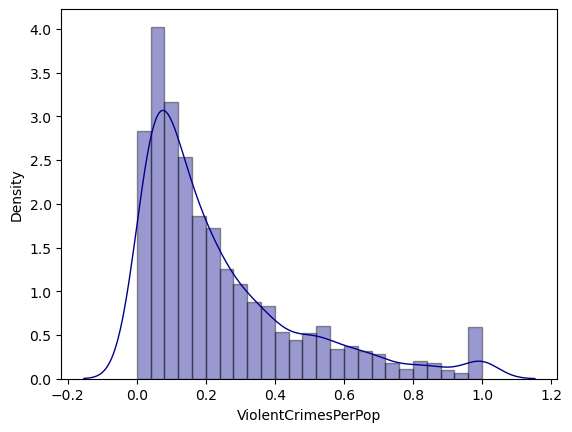

In [9]:
# Density Plot and Histogram of response variable
sns.distplot(community['ViolentCrimesPerPop'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
plt.show()

#### II. a Linearity  Examination

To study the relationship berween multiple predictors and the response variable, _**ViolentCrimesPerPop**_, the variables's correlation with the reponse variable are plotted below as a preliminary filter to examine the linearity. Although many of them seem to cluster around the zero point, indicating non-correlation; there are a decent number of predictors with strong positive and negative correlations with ViolentCrimesPerPop. 

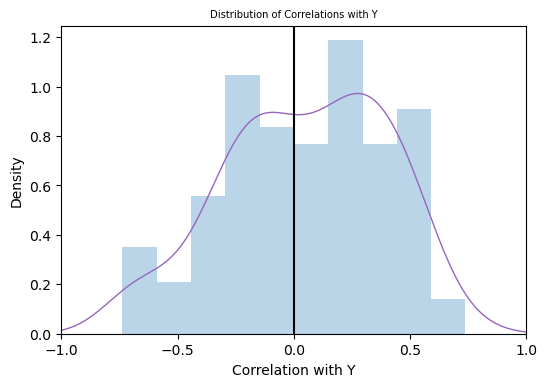

In [10]:
#Check for variable significance 
corr= xCrime.corrwith(yCrime)
f, ax = plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size':6})
ax.hist(corr, density=True, alpha=0.3)

ax = sns.kdeplot(corr, color="tab:purple", linewidth=1)
ax.axvline(0, color="black")
ax.set_title("Distribution of Correlations with Y")
ax.set_xlabel("Correlation with Y")
ax.set_xlim(-1, 1)
ax.set_xticks(np.linspace(-1, 1, 5))
plt.show()

Taking a close look, a variety of parameters shown on both the positive and negative tails of the correlation distribution. The variables displayed in purple are positively associated with crime; likewise, the blue ones are negatively associated with crime. 

On the very far ends, variables that have to do with the _**marital status**_ show up. On the positive side, it's "FemalePctDiv" and "ToTalPctDiv" which both measure the percentage of people who are divorced. On the other hand, "PctFam2Par" and "PctKids2Par", which measure percentage of -**families (with kids)**_ that are headed by two parents. Meantime, _**the racial variables**_ also shown as strong measurements on both tails, in which "racePctWhite" is the third strongest negative correlation, while "racePctBlack" being the second strongest variable on the positive tail.

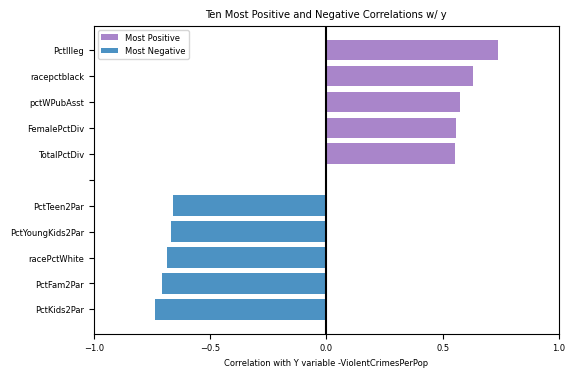

In [11]:
#Top & Bottom 5 significant variables 
k=5
sortedCorr= corr.sort_values(ascending=False)
sigVar= pd.concat([xCrime[sortedCorr.head(5).index], 
           xCrime[sortedCorr.tail(5).index]],axis='columns')

f, ax = plt.subplots(figsize=(6, 4))
plt.rcParams.update({'font.size':6})
top_range = range(10, 5, -1)
bottom_range = range(4, -1, -1)

ax.barh(top_range, sortedCorr.head(5), color="tab:purple", 
        alpha=0.8, label="Most Positive")
ax.axvline(0, color="black")
ax.barh(bottom_range, sortedCorr.tail(5), color="tab:blue", 
        alpha=0.8, label="Most Negative")

ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_xlabel("Correlation with Y variable -ViolentCrimesPerPop")

ax.set_yticks(range(10, -1, -1))
names = sortedCorr.head(5).index.tolist() + [""] + sortedCorr.tail(5).index.tolist()
ax.set_yticklabels(names)

ax.set_title("Ten Most Positive and Negative Correlations w/ y")
ax.legend()
plt.show()

#### II. b Multicollinearity Detection

Multicollinearity occurs when there are two or more independent variables in the multiple regression model, which have a high correlation among themselves. When some features are highly correlated, the model might have difficulty in distinguishing between their individual effects on the dependent variable. By using Variance Inflation Factor, collinearity is studied. Based on the output, there are a significant number of variables has high values of VIF, which means that many of the parameters can be almost entirely explained by other parameters. Hence, running straightforward MLA would results in highly biased model. 

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = xCrime.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(xCrime.values, i)
                          for i in range(len(xCrime.columns))]
vif_data[vif_data['VIF']>10]

,feature,VIF
0,population,349.790638
1,householdsize,204.120651
2,racepctblack,27.433824
3,racePctWhite,232.925171
5,racePctHisp,22.465773
...,...,...
89,PctForeignBorn,90.882785
90,PctBornSameState,79.884906
91,PctSameHouse85,120.654887
92,PctSameCity85,71.469956


#### II.c Extreme Positive and Negative Cases

Looking at the community with ViolentCrimesPerPop of 1 versus the one with ViolentCrimesPerPop of 0, _**the percentage of people living in urban areas**_ seems to be negatively associated with the response variable, whereas _**the percentage of households with farm or self employment income**_ have a positive association with crime. Interestingly, the percent of housing without complete plumbing facilities seems to postively associated with crime, which might referring to the wealthy index in certain community. 

In [13]:
def min_max_df(column):
    """return the top5 and bottom5 tuples"""
    top=pd.DataFrame(community.loc[community[column].idxmax()])
    bottom= pd.DataFrame(community.loc[community[column].idxmin()])
    info_df= pd.concat([top,bottom],axis=1)
    return info_df

CrimeComp=min_max_df("ViolentCrimesPerPop")
CrimeComp=CrimeComp.drop(["communityname"])
CrimeComp=CrimeComp.astype({82:"float",83:"float"})
##Possible Significant Feature
CrimeComp[CrimeComp.var(axis=1)>0.3]

,82,83
state,48.00,39.00
pctUrban,0.00,0.81
pctWFarmSelf,0.88,0.05
PctWOFullPlumb,0.90,0.09
ViolentCrimesPerPop,1.00,0.00


### III. Multiple Linear Regression 
#### III.a Model Building

Before running multiple linear regression, a column of 1s has been added to the dataframe as the coefficient for beta values, which allow to explicitly model the intercept as one of the model parameters.The resulting _**xCrime**_ dataframe after dropping irrelevant variables,has 1994 tuples measured with 99 parameters, while the _**yCrime**_ stores the value of _**ViolentCrimesPerPop**_ in array structure. After separating the target attribute for regression with a 20%-80% randomized split, the obtained regression coefficients is plotted as below. The resulting _**xTrain**_ dataframe has 1,595 tuples measured across 98 parameters, where as _**xTest**_ contains 399 observations. 

In [14]:
##Adding a column of 1s for beta coefficient 
xCrime["betaVal"]=1
##Move the last column to first
newCol=xCrime.columns.tolist()[-1:]+xCrime.columns.tolist()[:-1]
xCrime=xCrime[newCol]

#Array
yCrime=np.array(community["ViolentCrimesPerPop"])

print("Dimension of the predictors dataframe is:",(xCrime.shape))
print("Dimension of the target attribute for regression is:",(yCrime.shape))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xCrime, yCrime, test_size=0.2, random_state=961)

print(X_train.shape,X_test.shape)
X_train[0:3]

Dimension of the predictors dataframe is: (1994, 98)
Dimension of the target attribute for regression is: (1994,)
(1595, 98) (399, 98)


,betaVal,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans
1799,1,0.05,0.40,0.04,0.84,0.24,0.16,0.89,1.00,1.00,...,0.04,0.13,0.20,0.66,0.06,0.13,0.75,0.06,0.15,0.07
396,1,0.14,1.00,0.00,0.77,0.02,1.00,0.72,0.65,0.45,...,0.02,0.01,0.86,0.61,0.66,0.83,0.76,0.08,0.30,0.13
5,1,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,...,0.00,0.00,0.70,0.42,0.49,0.73,0.64,0.01,0.58,0.10


The function, _**standRegres()**_, is the function that computes the best-fit line. By loading the x and y arrays and then convert them into matrices, weight scores for each parameter are computed as follows.

In [15]:
def standRegres(xArr,yArr):
    """Load x and y arrays then convert into matrices.
    Return the beta values"""
    xMat = mat(xArr); yMat = mat(yArr).T
    #convert the x matrix into square matrix for multiplication
    xTx = xMat.T*xMat
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    #inverse of x * ((transpose of x)* y matrix)
    ws = xTx.I * (xMat.T*yMat)
    return ws

ws1=standRegres(X_train,y_train)
for i in range(len(X_train.columns[0:5])):    
    print('%7s     %2.2f'%(X_train.columns[i],ws1[i]))
print("...")
print(ws1.shape)

betaVal     0.39
population     -0.06
householdsize     -0.07
racepctblack     0.22
racePctWhite     -0.02
...
(98, 1)


,0,VarName
72,0.768051,PctHousOwnOcc
84,0.502257,MedRent
63,0.468602,PersPerOccupHous
37,0.452275,MalePctDivorce
57,0.405075,PctRecImmig8
...,...,...
78,-0.257519,OwnOccLowQuart
62,-0.273384,PctLargHouseOccup
43,-0.399460,PctKids2Par
40,-0.440425,TotalPctDiv


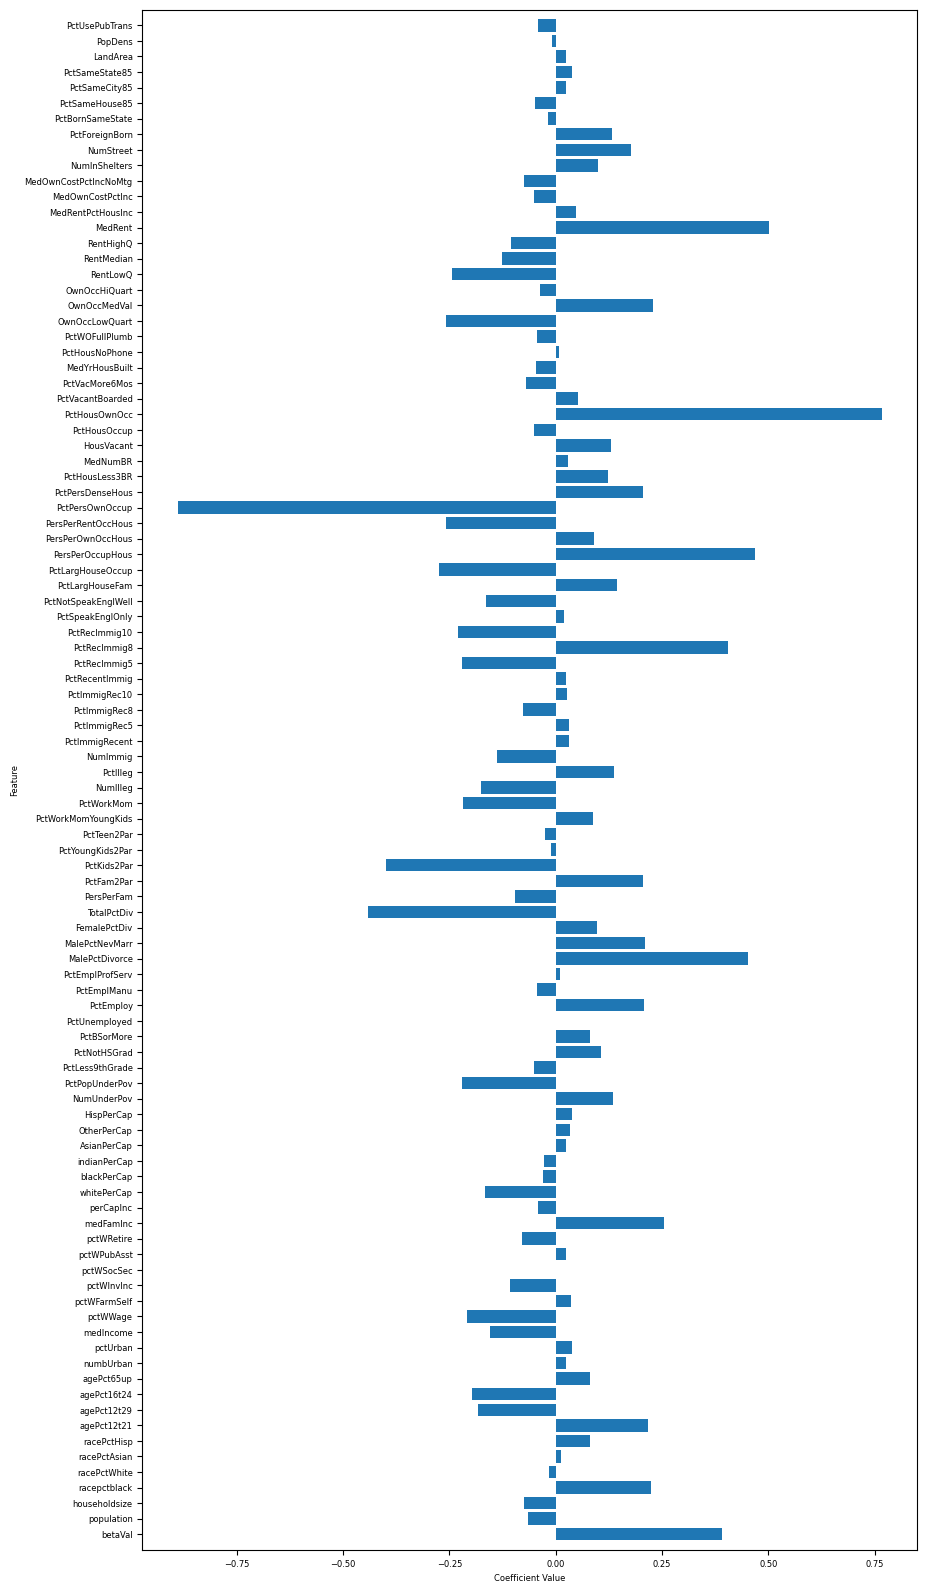

In [16]:
a= pd.DataFrame(ws1)
a['VarName']=X_train.columns

%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(10,20))
def plot_coefficients(weight, n_features, feature_names):
    pl.barh(range(n_features), weight, align='center')
    pl.yticks(np.arange(n_features), feature_names)
    pl.xlabel("Coefficient Value")
    pl.ylabel("Feature")
    pl.ylim(-1, n_features)

plot_coefficients(a[0],len(a),a['VarName'])
a.sort_values(by=[0],ascending=False)

#### III.b Model Analysis 

The RMSE result from the initial Multiple Linear Model of 0.1386, although appears acceptable, it is measured on the normalized dataset. Hence, the scale-dependent measurement does not explicitly indicates a good fit of the model, but needs to be compared with the results from other models.

In [17]:
#RMSE
def rmse(ws,xArr,yArr):
    xMat = mat(xArr);yMat = mat(yArr).T
    error= yMat-xMat*ws
    sq_error=np.square(error)
    rmse= np.sqrt(sq_error.sum()/len(sq_error))
    return rmse

rmse_train=rmse(ws1,X_train,y_train)

print("RMSE on the Training Data:",rmse_train)

RMSE on the Training Data: 0.12941693804105509


The correlation coefficients are:
[[1.         0.82853292]
 [0.82853292 1.        ]]
The correlation coefficients are:
[[1.         0.83833806]
 [0.83833806 1.        ]]


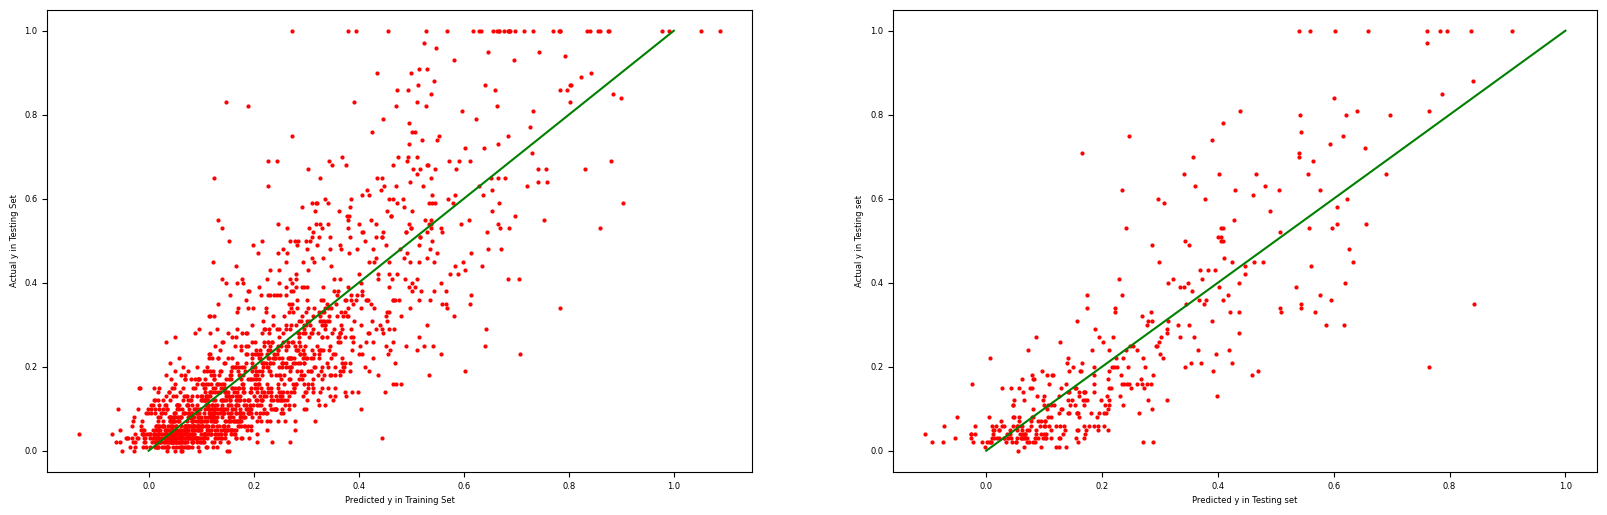

In [18]:
# Plot predicted against actual (in the training data)
yhat=mat(X_train)*ws1
print("The correlation coefficients are:")
print(corrcoef(yhat.T,mat(y_train)))

# Plot predicted against actual (in the testing data)
yhat_test=mat(X_test)*ws1
print("The correlation coefficients are:")
print(corrcoef(yhat_test.T,mat(y_test)))

%matplotlib inline
figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(yhat, y_train,'ro', markersize=2)
plt.plot([0,1],[0,1], 'g-')
plt.xlabel('Predicted y in Training Set')
plt.ylabel('Actual y in Testing Set')

plt.subplot(1,2,2)
plt.plot(yhat_test, y_test,'ro', markersize=2)
plt.plot([0,1],[0,1], 'g-')
plt.xlabel('Predicted y in Testing set')
plt.ylabel('Actual y in Testing set')
plt.show()

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error 

def cross_validate(xArr, yArr, nFold, verbose=False):
    """take xArr - the training data matrix;
            yArr: the training target variable array;
            nFold: the number of fold for x-validation;
        and returns mean RMSE across all folds"""
    kFold = KFold(n_splits=nFold)                                             
    xval_err = 0
    f = 1
    for train_index,test_index in kFold.split(xArr):
        X_train , X_test = xArr.iloc[train_index,:],xArr.iloc[test_index,:]
        y_train , y_test = yArr[train_index] , yArr[test_index]
        
        weightScore=standRegres(X_train,y_train)
        rmseTest= rmse(weightScore,X_test,y_test)
        if verbose:
            print("Fold %2d RMSE: %.4f" % (f, rmseTest))
        xval_err += rmseTest
        f += 1
    return xval_err/nFold

rmse_10cv= cross_validate(X_train,y_train, 10, verbose=True)
method = 'Linear Regression for ViolentCrimesPerPop'
print('\n')
print('Method: %s' %method)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Fold  1 RMSE: 0.1270
Fold  2 RMSE: 0.1400
Fold  3 RMSE: 0.1367
Fold  4 RMSE: 0.1275
Fold  5 RMSE: 0.1407
Fold  6 RMSE: 0.1373
Fold  7 RMSE: 0.1354
Fold  8 RMSE: 0.1622
Fold  9 RMSE: 0.1269
Fold 10 RMSE: 0.1522


Method: Linear Regression for ViolentCrimesPerPop
RMSE on training: 0.1294
RMSE on 10-fold CV: 0.1386


### IV. Feature Selection

To improve interpretability, and sometimes also generalization performance, feature selection is used to select a subset of the original features. For a given supervised model, the best feature selection strategy select the optimal percentage of the most informative feature subset to use, measured by scross validated R-square and MSE values. As in output, the model with the highest R-sq value of 0.63 selected 31 features out of 98 total features, with a RMSE value of 0.139. Worth noting, the RMSE is worse than the result for MLR model, hence a reduced subset of Features therefore does not improve the performance of the linear model.

Meantime,the plot of the RMSE vs the percentage of predictors included shows that the error reduces with the number of features added to the dataset, indicating the bias-variance tradeoff. In a nutshell, model with high bias pays very little attention to the training data and oversimplifies the model, which often leads to high error on training and test data. On the other hand, the resulting optimal model with high variance pays extra attention to the training data and performs better than the rest model without generalizing on unseen data. 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection 
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [21]:
def featureBest(xArr,yArr,model,percentiles):
    """The function for feature selection takes as input the training 
    data, target variable, the model, and the number of folds. By using 
    k-fold cross-validation on x, returns the optimal percentage of the 
    most informative features to use. """
    
    results=[[],[]]
    for i in percentiles:
        fSelect= SelectPercentile(f_regression, percentile=i)
        #Apply feature selection to entire matrix
        X_train_fs=fSelect.fit_transform(xArr,yArr)
        
        #Using the R-sq metric for the applied model, close to 1 implies a better fit
        R_scores=cross_val_score(linreg,X_train_fs,yArr,cv=5)
        MSE_scores = cross_val_score(linreg, X_train_fs, yArr, 
                                     scoring="neg_root_mean_squared_error", 
                                     cv=5,n_jobs=1)
        mean_Rsq= np.mean(R_scores)
        mean_RMSE= np.mean(np.abs(MSE_scores))
        
        results[0] = np.append(results[0], mean_Rsq)
        results[1] = np.append(results[1],mean_RMSE)    
        
    #the percentile of model with maximized R-sqaure 
    ##return the first model
    optimal_percentile_ind=np.where(results[0] == results[0].max())[0][0]
    
    optimal_percentile=percentiles[optimal_percentile_ind]
    optimal_num_features = int(optimal_percentile*len(xArr.columns)/100)
    
    fBest= SelectPercentile(f_regression, percentile=optimal_percentile)
    #Apply feature selection to entire matrix
    
    xBest_fs=fBest.fit_transform(xArr,yArr)
    
    xSelected = fBest.get_support()
    
    xFeatures = [f for i,f in enumerate(xArr.columns) if xSelected[i]]
    print('Model w/Highest R-sq {} Selected {} features'.format(results[0][optimal_percentile_ind],xSelected.sum()))
    print('Model RMSE: {}\n'.format(results[1][optimal_percentile_ind]))
    
    featureScore={}
    for P in range(len(xArr.columns.values)):
        if fBest.get_support()[P]:
            featureScore[xArr.columns.values[P]]= fBest.scores_[P]
            print("%10s  %3.2f" % (xArr.columns.values[P], fBest.scores_[P]))
      
    return results, featureScore

percentiles=range(1,100,5)
linreg=LinearRegression().fit(X_train,y_train)
fs=featureBest(X_train,y_train,linreg,percentiles)

Model w/Highest R-sq 0.6345053393887847 Selected 31 features
Model RMSE: 0.13921648877902632

population  275.84
racepctblack  1048.91
racePctWhite  1367.02
 numbUrban  267.97
 medIncome  334.16
pctWInvInc  740.41
pctWPubAsst  729.01
 medFamInc  359.55
NumUnderPov  433.49
PctPopUnderPov  546.20
PctLess9thGrade  308.10
PctNotHSGrad  465.93
PctUnemployed  523.44
MalePctDivorce  586.36
FemalePctDiv  678.98
TotalPctDiv  671.85
PctFam2Par  1502.10
PctKids2Par  1832.13
PctYoungKids2Par  1174.12
PctTeen2Par  1191.72
  NumIlleg  490.12
  PctIlleg  1875.40
PctLargHouseFam  254.82
PctPersOwnOccup  584.80
PctPersDenseHous  384.54
PctHousLess3BR  456.97
HousVacant  365.64
PctHousOwnOcc  442.19
PctVacantBoarded  494.13
PctHousNoPhone  456.72
NumInShelters  278.06


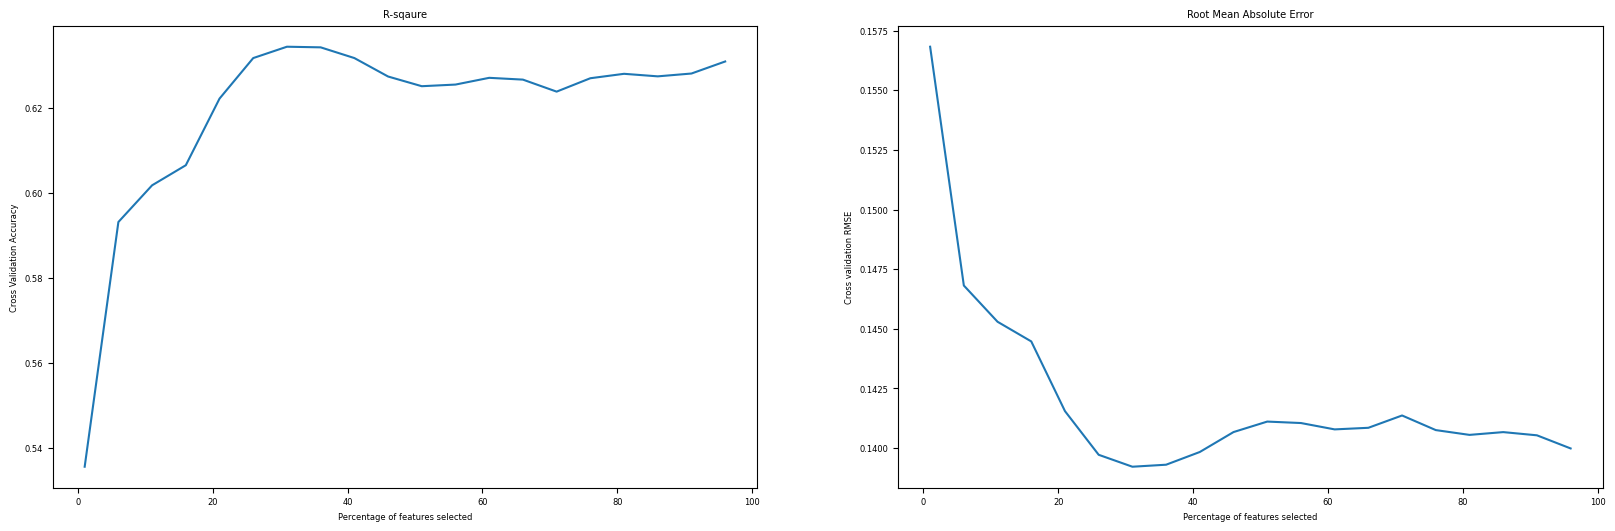

In [22]:
figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.plot(percentiles,fs[0][0])
plt.title("R-sqaure")
plt.xlabel("Percentage of features selected")
plt.ylabel("Cross Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(percentiles,fs[0][1])
plt.title("Root Mean Absolute Error")
plt.xlabel("Percentage of features selected")
plt.ylabel("Cross validation RMSE")
plt.show()

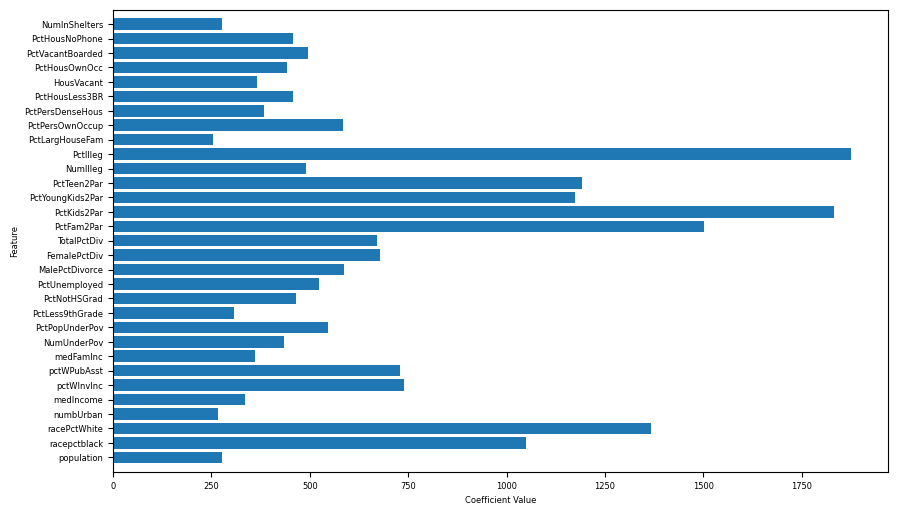

In [23]:
figure(figsize=(10,6))
plot_coefficients(fs[1].values(),len(fs[1].keys()),fs[1].keys())

### V. Ridge Regression 

#### V.a Model Building
Ridge regression is a regularized regression method that performs L2 regularization by equaling the square of the magnitude of all the coefficients with the penalty value. The _**ridgeRegres()**_ function takes an alpha argument that is used to tune the model. The array of alpha values ranging from 0 to 10, where the large penalty shrinks the coefficients to a arge degree, essentially reducing to a model containing just the intercept and a very few predictors, which makes the model more biased, resulting in a higher MSE.Cross Validation was used to find the best value of the regularization parameter, lambda, using 5-fold selection

In [25]:
def ridgeRegres(xArr, yArr,alpha,nfold):
    """Function takes as input the predictor and target variables, the alpha 
    parameter to vary,and the number of folds for x-validation.It returns a dataframe
    containing the RMSE and CV_RMSE for each alpha parameter"""
    
    train_rmse = np.array([])
    cv_rmse = np.array([])
    diff=np.array([])
    
    for a in alpha:
        ridge= Ridge(alpha=a)
        ridge.fit(xArr,yArr)        
        #yHat is the array of predicted training y values 
        yHat= ridge.predict(xArr)       
        mse_train= mean_squared_error(yArr,yHat)   
        rmse_train= sqrt(mse_train)
        
        #compute RMSE using x-validation 
        cv_output = cross_val_score(ridge, xArr, yArr,cv=nfold,
                                    scoring="neg_root_mean_squared_error")
        rmse_score= -(cv_output.mean())
        
        #compute the difference
        gap= rmse_score - rmse_train        
        train_rmse=np.append(train_rmse,[rmse_train])
        cv_rmse= np.append(cv_rmse,[rmse_score])
        diff= np.append(diff,[gap])
        
    results= pd.DataFrame({'Alpha':alpha,'RMSE_train':list(train_rmse),'CV_RMSE':list(cv_rmse),
                          'Diff':diff},
                          columns=['Alpha','RMSE_train','CV_RMSE','Diff'])
    return results

In [26]:
alpha = np.linspace(.001,10.0,100) 
ridge_df= ridgeRegres(X_train,y_train,alpha,5)
ridge_df

,Alpha,RMSE_train,CV_RMSE,Diff
0,0.001,0.129417,0.139756,0.010339
1,0.102,0.129587,0.139092,0.009506
2,0.203,0.129745,0.138811,0.009066
3,0.304,0.129881,0.138624,0.008743
4,0.405,0.130002,0.138485,0.008484
...,...,...,...,...
95,9.596,0.133560,0.138099,0.004539
96,9.697,0.133578,0.138104,0.004525
97,9.798,0.133596,0.138108,0.004512
98,9.899,0.133615,0.138113,0.004498


#### V.b Model Evaluation
Based on the output, the optimal alpha selected for Ridge Regression is 3.132, with the lowest cross-validated RMSE of 0.129 on train set. However, fitting a ridge regression model with alpha = 3.132 does not seem to lead to a much lower test MSE than fitting a model with just the intercept - the model with alpha of 0. 

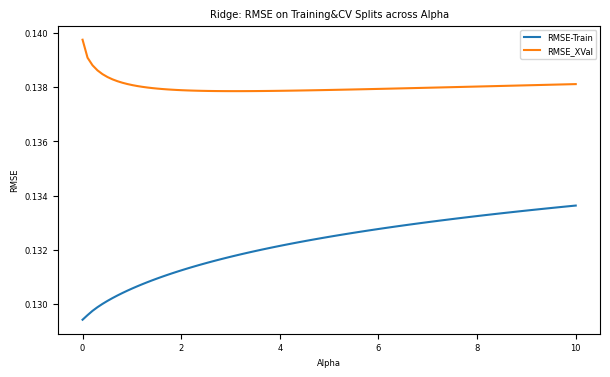

In [27]:
fig = pl.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(ridge_df["Alpha"], ridge_df["RMSE_train"], label='RMSE-Train')
ax.plot(ridge_df["Alpha"], ridge_df["CV_RMSE"], label='RMSE_XVal')
pl.rcParams.update({'font.size':6})
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.title('Ridge: RMSE on Training&CV Splits across Alpha')
pl.show()

In [28]:
#lowest cv-RMSE score 
optimal_alpha_ind=np.where(ridge_df['CV_RMSE'] == ridge_df['CV_RMSE'].min())[0]
optimal_alpha=alpha[optimal_alpha_ind]
lowest_RMSE= ridge_df['RMSE_train'].min()

print("Optimal Alpha for Ridge Regression:{0}, with the lowest RMSE of {1} on train set".
      format(optimal_alpha,round(lowest_RMSE,3)))

Optimal Alpha for Ridge Regression:[3.132], with the lowest RMSE of 0.129 on train set


In [29]:
#Ridge model on test set
ridge_test= Ridge(alpha=3.132)
ridge_test.fit(X_train,y_train)
yHat= ridge_test.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(yHat,y_train))

yHat_test= ridge_test.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(yHat_test,y_test))

method_name = 'Ridge Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on test data: %.4f' %rmse_test)

Method: Ridge Regression
RMSE on training: 0.1318
RMSE on test data: 0.1324


### VI. Lasso Regression

#### VI.a Model Building
To examine whether the lasso can yield either a more accurate or a more interpretable model than ridge regression, model is built as follows. As with Ridge Regression, the Lasso shrinks the coefficient estimates towards zero. However, in the case of the Lasso, the regularization penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter lamda is sufficiently large. Hence, much like best subset selection, the Lasso performs variable selection, whereas Ridge does not.Cross validation was used to find the optimal value of lamda using the value of 5 fold selection, which was then used in the fitted model to predict on the test data subset.

In [30]:
def lassoRegres(xArr, yArr,alpha,nfold):
    """Function takes as input the predictor and target variables, the alpha 
    parameter to vary,and the number of folds for x-validation.It returns a dataframe
    containing the RMSE and CV_RMSE for each alpha parameter"""
    
    train_rmse = np.array([])
    cv_rmse = np.array([])
    diff=np.array([])
    
    for a in alpha:
        lasso= Lasso(alpha=a)
        lasso.fit(xArr,yArr)
        
        #yHat is the array of predicted training y values 
        yHat= lasso.predict(xArr)        
        rmse_train=np.sqrt(mean_squared_error(yArr,yHat))  
       
        #compute RMSE using x-validation 
        cv_output = cross_val_score(lasso, xArr, yArr,cv=nfold,
                                    scoring="neg_root_mean_squared_error")
        rmse_score= -(cv_output.mean())
        
        #compute the difference
        gap= rmse_score - rmse_train
        
        train_rmse=np.append(train_rmse,[rmse_train])
        cv_rmse= np.append(cv_rmse,[rmse_score])
        diff= np.append(diff,[gap])
        

    results= pd.DataFrame({'Alpha':alpha,'RMSE_train':list(train_rmse),'CV_RMSE':list(cv_rmse),
                          'Diff':diff},
                          columns=['Alpha','RMSE_train','CV_RMSE','Diff'])
    return results

In [31]:
alpha_lasso = np.linspace(.001,10.0,100) 
lasso_df= lassoRegres(X_train,y_train,alpha_lasso,5)
lasso_df

,Alpha,RMSE_train,CV_RMSE,Diff
0,0.001,0.136113,0.138297,0.002184
1,0.102,0.231126,0.231007,-0.000119
2,0.203,0.231126,0.231007,-0.000119
3,0.304,0.231126,0.231007,-0.000119
4,0.405,0.231126,0.231007,-0.000119
...,...,...,...,...
95,9.596,0.231126,0.231007,-0.000119
96,9.697,0.231126,0.231007,-0.000119
97,9.798,0.231126,0.231007,-0.000119
98,9.899,0.231126,0.231007,-0.000119


#### VI.b Model Evaluation
Based on the output, the RMSE is substantially worse than the RMSE of ridge regression with alpha chosen by cross-validation. The plot of RMSE versus alpha shows that the lowest Mean Square error was produced with a extremely small value of lambda, indicating that reducing the feature coefficients does not improve model performance.

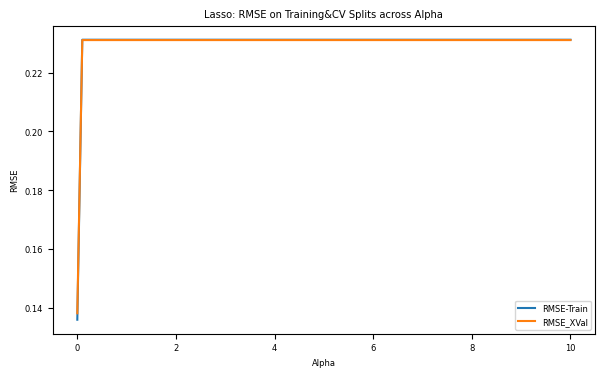

In [32]:
fig = pl.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(lasso_df["Alpha"], lasso_df["RMSE_train"], label='RMSE-Train')
ax.plot(lasso_df["Alpha"], lasso_df["CV_RMSE"], label='RMSE_XVal')
pl.rcParams.update({'font.size':6})
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.title('Lasso: RMSE on Training&CV Splits across Alpha')
pl.show()

In [33]:
#lowest cv-RMSE score 
optimal_alpha_ind=np.where(lasso_df['CV_RMSE'] == lasso_df['CV_RMSE'].min())[0]
optimal_alpha=alpha_lasso[optimal_alpha_ind]
lowest_RMSE= lasso_df['RMSE_train'].min()

lowest_RMSE

0.13611309860731097

In [34]:
#Lasso model on test set
lasso_test= Lasso(alpha=0.001)
lasso_test.fit(X_train,y_train)
yHat= lasso_test.predict(X_train)
rmse_train=np.sqrt(mean_squared_error(yHat,y_train))

yHat_test= lasso_test.predict(X_test)
rmse_test= np.sqrt(mean_squared_error(yHat_test,y_test))

method_name = 'Lasso Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on test data: %.4f' %rmse_test)

Method: Lasso Regression
RMSE on training: 0.1361
RMSE on test data: 0.1370


### VII. Stochastic Gradient Descent for ElasticNet Regression.

#### VII.a Model Building 

In [35]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [36]:
#Dataframe for regression 
xVal= community.drop(["state","communityname","ViolentCrimesPerPop"],axis=1)
#Array
yVal=np.array(community["ViolentCrimesPerPop"])

print("Dimension of the predictors dataframe is:",(xVal.shape))
print("Dimension of the target attribute for regression is:",(yVal.shape))
xTrain, xTest, yTrain, yTest = train_test_split(xVal, yVal, test_size=0.2, random_state=961)
print('\n')
print("Dimension of the predictors dataframe in Train set is:",(xTrain.shape))
print("Dimension of the target attribute in Train set is:",(yTrain.shape))

Dimension of the predictors dataframe is: (1994, 97)
Dimension of the target attribute for regression is: (1994,)


Dimension of the predictors dataframe in Train set is: (1595, 97)
Dimension of the target attribute in Train set is: (1595,)


By performing a grid search using GridSearchCV between the two penalty parameters ('l2', 'l1') and different values of alpha, the best RMSE score achieved is 0.14 with alpha of 0.01, corresponding to L2 penalty. However, using elastic net with GridSearchCV of different parameter for the best mixing ratio, the best model achieves a slightly lower RMSE using _**an alpha value of 0.1**_ and _**l1_ratio' of 0.02**_. Using the best mixing ratio with Stochastic Gradient Descent Regression, the _**RMSE on test data is 0.1351**_. 

In [42]:
# define models and parameters
scaler = StandardScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

par={
    'penalty' :['l1','l2'],
    'alpha':np.linspace(.001,10.0,100) 
}
sgdreg = SGDRegressor(random_state=961)
grid_search = GridSearchCV(estimator=sgdreg,param_grid=par, 
                           scoring="neg_root_mean_squared_error",cv=5)
grid_result = grid_search.fit(xTrain, yTrain)

# summarize results
print("Best: %f using %s" % (abs(grid_result.best_score_), 
                             grid_result.best_params_))

Best: 0.139135 using {'alpha': 0.001, 'penalty': 'l1'}


In [41]:
#Fit only the training data and apply same transformation to both
param= {
    # learning rate, the higher the alpha value, the stronger the regularization
    'alpha': np.linspace(.001,10.0,100) , 
    #an array of evenly spaced number between .001 and 1.0
    'l1_ratio':np.linspace(.001,1.0,100),
    'penalty': ['elasticnet']
}

sgdreg = SGDRegressor(random_state=961)
gridSearch= GridSearchCV(sgdreg,param,scoring="neg_root_mean_squared_error",
                        cv=5)

#Fit the model
gridSearch.fit(xTrain,yTrain)
print("Best score: " + str(abs(gridSearch.best_score_)))
print("Best parameter: " + str(gridSearch.best_params_))

Best score: 0.13909416885762133
Best parameter: {'alpha': 0.10200000000000001, 'l1_ratio': 0.021181818181818184, 'penalty': 'elasticnet'}


In [44]:
means = gridSearch.cv_results_['mean_test_score'][:5]
stds = gridSearch.cv_results_['std_test_score'][:5]
params = gridSearch.cv_results_['params'][:5]
 
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (abs(mean), stdev, param))

0.139988 (0.005240) with: {'alpha': 0.001, 'l1_ratio': 0.001, 'penalty': 'elasticnet'}
0.139966 (0.005212) with: {'alpha': 0.001, 'l1_ratio': 0.011090909090909092, 'penalty': 'elasticnet'}
0.139948 (0.005188) with: {'alpha': 0.001, 'l1_ratio': 0.021181818181818184, 'penalty': 'elasticnet'}
0.139937 (0.005167) with: {'alpha': 0.001, 'l1_ratio': 0.03127272727272727, 'penalty': 'elasticnet'}
0.139931 (0.005152) with: {'alpha': 0.001, 'l1_ratio': 0.041363636363636366, 'penalty': 'elasticnet'}


In [50]:
# Compute RMSE on train data
pTrain= gridSearch.predict(xTrain)
rmse_train = np.sqrt(mean_squared_error(pTrain, yTrain))

In [51]:
# Compute RMSE on the set-aside test data
pTest = gridSearch.predict(xTest) # predictions on the test instances
rmse_test = np.sqrt(mean_squared_error(pTest, yTest))

method_name = 'Stochastic Gradient Descent Regression'
print("\n")
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on test data: %.4f' %rmse_test)



Method: Stochastic Gradient Descent Regression
RMSE on training: 0.1356
RMSE on test data: 0.1351
